# Lab Quest 3 - Big Data Analytics
Maciej Lorens

In [ ]:
# Import necessary libraries
import pyspark
from pyspark import SparkConf, SparkContext
import sys
from pyspark.sql import SparkSession, types, SQLContext
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.sql.functions import regexp_extract
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [ ]:
spark = SparkSession.builder.appName("labs app").getOrCreate()

## Data exploration and preprocessing

### Movies.csv

In [ ]:
# Load the dataframe with movie titles and genres
movies_df = spark.read.format("csv") \
    .option("inferSchema", "false") \
        .option("header", "true") \
            .option("sep", ",") \
                .load("/FileStore/tables/movies.csv")
movies_df.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [ ]:
# Print schema
movies_df.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [ ]:
# Cast movieId to integer
movies_df = movies_df.withColumn("movieId", movies_df["movieId"].cast("int"))

In [ ]:
# How many movies are there in the table?
movies_df.distinct().count()

Out[9]: 27278

In [ ]:
# It might be useful to extract the year of the movie. Some users might not enjoy older movies (black and white, worse quality of sound and special effects).
movies_df = movies_df.withColumn("year", regexp_extract(movies_df["title"], r"\((\d{4})\)", 1))

# Also it might be better to encode it into a decade
movies_df = movies_df.withColumn("decade", expr("floor(year / 10) * 10"))

In [ ]:
# Are there any NAs in decade?
movies_df.where(col("decade").isNull()).show()

+-------+--------------------+--------------------+----+------+
|movieId|               title|              genres|year|decade|
+-------+--------------------+--------------------+----+------+
|  40697|           Babylon 5|              Sci-Fi|    |  null|
|  79607|Millions Game, Th...|Action|Drama|Sci-...|    |  null|
|  87442|Bicycle, Spoon, A...|         Documentary|    |  null|
| 107434|Diplomatic Immuni...|              Comedy|    |  null|
| 108548|Big Bang Theory, ...|              Comedy|    |  null|
| 108583|Fawlty Towers (19...|              Comedy|    |  null|
| 112406|Brazil: In the Sh...|         Documentary|    |  null|
| 113190|  Slaying the Badger|         Documentary|    |  null|
| 115133|Tatort: Im Schmer...|               Crime|    |  null|
| 115685|National Theatre ...|       Drama|Fantasy|    |  null|
| 125571|The Court-Martial...|  (no genres listed)|    |  null|
| 125632|       In Our Garden|  (no genres listed)|    |  null|
| 125958|Stephen Fry In Am...|  (no genr

In [ ]:
# Fill NAs with 0
movies_df = movies_df.fillna({"decade": 0})

In [ ]:
movies_df.show()

+-------+--------------------+--------------------+----+------+
|movieId|               title|              genres|year|decade|
+-------+--------------------+--------------------+----+------+
|      1|    Toy Story (1995)|Adventure|Animati...|1995|  1990|
|      2|      Jumanji (1995)|Adventure|Childre...|1995|  1990|
|      3|Grumpier Old Men ...|      Comedy|Romance|1995|  1990|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|1995|  1990|
|      5|Father of the Bri...|              Comedy|1995|  1990|
|      6|         Heat (1995)|Action|Crime|Thri...|1995|  1990|
|      7|      Sabrina (1995)|      Comedy|Romance|1995|  1990|
|      8| Tom and Huck (1995)|  Adventure|Children|1995|  1990|
|      9| Sudden Death (1995)|              Action|1995|  1990|
|     10|    GoldenEye (1995)|Action|Adventure|...|1995|  1990|
|     11|American Presiden...|Comedy|Drama|Romance|1995|  1990|
|     12|Dracula: Dead and...|       Comedy|Horror|1995|  1990|
|     13|        Balto (1995)|Adventure|

In [ ]:
# Split the "genres" column by "|" and explode to get individual genres
movies_df = movies_df.withColumn("genres", explode(split(movies_df["genres"], "\\|")))
temp_df = movies_df.withColumn("genres", explode(split(movies_df["genres"], "\\|")))

# Get unique genres from the DataFrame
unique_genres = movies_df.select("genres").distinct().rdd.flatMap(lambda x: x).collect()

In [ ]:
# Create binary columns for each unique genre
for genre in unique_genres:
    movies_df = movies_df.withColumn(genre, (movies_df["genres"] == genre).cast("int"))

# Aggregate by movie to get the final result
movies_df = movies_df.groupBy("movieId", "title", "decade").agg(*[pyspark.sql.functions.max(genre).alias(genre) for genre in unique_genres]).orderBy("movieId")

movies_df.show()

+-------+--------------------+------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------------------+----+------+-------+------+--------+------+------+
|movieId|               title|decade|Crime|Romance|Thriller|Adventure|Drama|War|Documentary|Fantasy|Mystery|Musical|Animation|Film-Noir|(no genres listed)|IMAX|Horror|Western|Comedy|Children|Action|Sci-Fi|
+-------+--------------------+------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------------------+----+------+-------+------+--------+------+------+
|      1|    Toy Story (1995)|  1990|    0|      0|       0|        1|    0|  0|          0|      1|      0|      0|        1|        0|                 0|   0|     0|      0|     1|       1|     0|     0|
|      2|      Jumanji (1995)|  1990|    0|      0|       0|        1|    0|  0|          0|      1|      0|      0|        0|        0|                 0|   0|     0|      0| 

In [ ]:
# Which genre is the most common?
temp_df.groupBy("genres").count().orderBy(desc("count")).show()

+------------------+-----+
|            genres|count|
+------------------+-----+
|             Drama|13344|
|            Comedy| 8374|
|          Thriller| 4178|
|           Romance| 4127|
|            Action| 3520|
|             Crime| 2939|
|            Horror| 2611|
|       Documentary| 2471|
|         Adventure| 2329|
|            Sci-Fi| 1743|
|           Mystery| 1514|
|           Fantasy| 1412|
|               War| 1194|
|          Children| 1139|
|           Musical| 1036|
|         Animation| 1027|
|           Western|  676|
|         Film-Noir|  330|
|(no genres listed)|  246|
|              IMAX|  196|
+------------------+-----+



### Ratings.csv

In [ ]:
# Load the dataframe with user ratings
ratings_df = spark.read.format("csv") \
    .option("inferSchema", "false") \
        .option("header", "true") \
            .option("sep", ",") \
                .load("/FileStore/tables/ratings.csv")
ratings_df.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      2|   3.5|1112486027|
|     1|     29|   3.5|1112484676|
|     1|     32|   3.5|1112484819|
|     1|     47|   3.5|1112484727|
|     1|     50|   3.5|1112484580|
|     1|    112|   3.5|1094785740|
|     1|    151|   4.0|1094785734|
|     1|    223|   4.0|1112485573|
|     1|    253|   4.0|1112484940|
|     1|    260|   4.0|1112484826|
|     1|    293|   4.0|1112484703|
|     1|    296|   4.0|1112484767|
|     1|    318|   4.0|1112484798|
|     1|    337|   3.5|1094785709|
|     1|    367|   3.5|1112485980|
|     1|    541|   4.0|1112484603|
|     1|    589|   3.5|1112485557|
|     1|    593|   3.5|1112484661|
|     1|    653|   3.0|1094785691|
|     1|    919|   3.5|1094785621|
+------+-------+------+----------+
only showing top 20 rows



In [ ]:
ratings_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [ ]:
# What is the scale of ratings?
ratings_df.select("rating").distinct().orderBy(desc("rating")).show()

+------+
|rating|
+------+
|   5.0|
|   4.5|
|   4.0|
|   3.5|
|   3.0|
|   2.5|
|   2.0|
|   1.5|
|   1.0|
|   0.5|
+------+



In [ ]:
# Subsample the data with original frequencies of ratings kept
ratings_df = ratings_df.sampleBy("rating", fractions={"0.5": 0.01, "1.0": 0.01, "1.5": 0.01, "2.0": 0.01, "2.5": 0.01, "3.0": 0.01, "3.5": 0.01, "4.0": 0.01, "4.5": 0.01, "5.0": 0.01}, seed=42)

# Show the result
ratings_df.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     3|    512|   2.0| 945176005|
|     3|   1272|   4.0| 944918124|
|     3|   2694|   4.0| 944897855|
|     7|   2959|   4.0|1011209096|
|    11|   4340|   4.0|1230785185|
|    11|   4896|   5.0|1230859199|
|    11|   5219|   5.0|1230788070|
|    11|  37380|   2.0|1230787597|
|    11|  56145|   5.0|1251170092|
|    11|  63859|   4.5|1251143342|
|    11|  66171|   4.5|1251169681|
|    12|    590|   3.0| 859063999|
|    13|    266|   5.0| 849082652|
|    14|    440|   4.5|1225320131|
|    14|   1302|   3.0|1225311921|
|    14|   2716|   3.5|1225308996|
|    14|   2761|   4.0|1225314416|
|    14|   3751|   4.5|1225309045|
|    15|    326|   3.0| 840207366|
|    17|   1610|   4.0| 979686275|
+------+-------+------+----------+
only showing top 20 rows



In [ ]:
# How many ratings are there in the table now?
ratings_df.distinct().count()

Out[21]: 200810

### Joining movies and ratings dataframes

In [ ]:
all_df = ratings_df.join(movies_df, ["movieId"], "inner")
all_df.show()

+-------+------+------+----------+--------------------+------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------------------+----+------+-------+------+--------+------+------+
|movieId|userId|rating| timestamp|               title|decade|Crime|Romance|Thriller|Adventure|Drama|War|Documentary|Fantasy|Mystery|Musical|Animation|Film-Noir|(no genres listed)|IMAX|Horror|Western|Comedy|Children|Action|Sci-Fi|
+-------+------+------+----------+--------------------+------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------------------+----+------+-------+------+--------+------+------+
|    512|     3|   2.0| 945176005|Puppet Masters, T...|  1990|    0|      0|       0|        0|    0|  0|          0|      0|      0|      0|        0|        0|                 0|   0|     1|      0|     0|       0|     0|     1|
|   1272|     3|   4.0| 944918124|       Patton (1970)|  1970|    0|      0|

In [ ]:
all_df.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- title: string (nullable = true)
 |-- decade: long (nullable = false)
 |-- Crime: integer (nullable = true)
 |-- Romance: integer (nullable = true)
 |-- Thriller: integer (nullable = true)
 |-- Adventure: integer (nullable = true)
 |-- Drama: integer (nullable = true)
 |-- War: integer (nullable = true)
 |-- Documentary: integer (nullable = true)
 |-- Fantasy: integer (nullable = true)
 |-- Mystery: integer (nullable = true)
 |-- Musical: integer (nullable = true)
 |-- Animation: integer (nullable = true)
 |-- Film-Noir: integer (nullable = true)
 |-- (no genres listed): integer (nullable = true)
 |-- IMAX: integer (nullable = true)
 |-- Horror: integer (nullable = true)
 |-- Western: integer (nullable = true)
 |-- Comedy: integer (nullable = true)
 |-- Children: integer (nullable = true)
 |-- Action: integer (nullable = tr

### Visualizations

In [ ]:
# Create a dataframe for visualization
top_rated = ratings_df.join(temp_df, ["movieId"], "inner").orderBy("movieId")
top_rated.show()

+-------+------+------+----------+----------------+---------+----+------+
|movieId|userId|rating| timestamp|           title|   genres|year|decade|
+-------+------+------+----------+----------------+---------+----+------+
|      1|123238|   4.0|1230808043|Toy Story (1995)|Adventure|1995|  1990|
|      1|123903|   5.0| 847141387|Toy Story (1995)|Adventure|1995|  1990|
|      1|123354|   5.0| 835057979|Toy Story (1995)|  Fantasy|1995|  1990|
|      1|123238|   4.0|1230808043|Toy Story (1995)|Animation|1995|  1990|
|      1|123354|   5.0| 835057979|Toy Story (1995)|   Comedy|1995|  1990|
|      1|122488|   3.0|1141890501|Toy Story (1995)|  Fantasy|1995|  1990|
|      1|123354|   5.0| 835057979|Toy Story (1995)| Children|1995|  1990|
|      1|122488|   3.0|1141890501|Toy Story (1995)|Animation|1995|  1990|
|      1|123354|   5.0| 835057979|Toy Story (1995)|Animation|1995|  1990|
|      1|122488|   3.0|1141890501|Toy Story (1995)| Children|1995|  1990|
|      1|123354|   5.0| 835057979|Toy 

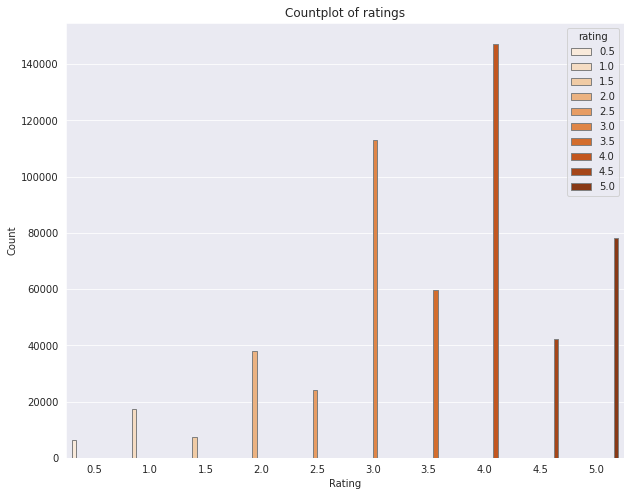

In [ ]:
# The count of each rating
histogram_data = top_rated.groupBy("rating").count().orderBy("rating").toPandas()

# Specify the order of ratings
hue_order = sorted(histogram_data["rating"].unique())

plt.figure(figsize=(10, 8))
sns.barplot(data=histogram_data, x="rating"
            , y="count", hue="rating"
            , hue_order=hue_order
            , palette="Oranges", edgecolor="grey")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Countplot of ratings")
plt.show()

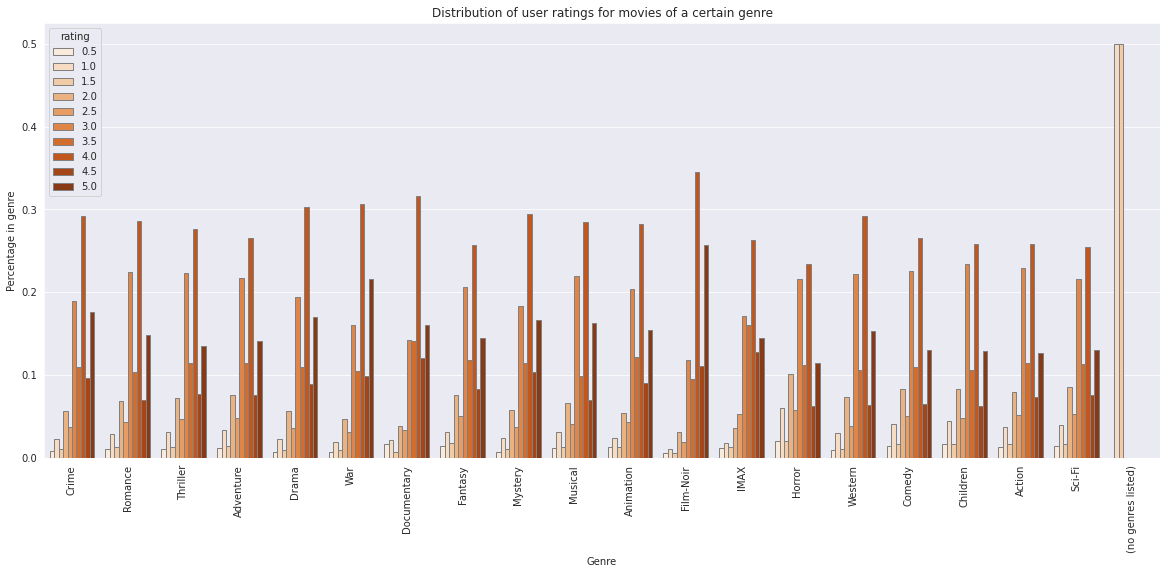

In [ ]:
# Calculate the histogram for each genre and rating using Spark
histogram_data = top_rated.groupBy("genres", "rating").count()

# Calculate the total count for each genre
total_counts = top_rated.groupBy("genres").count().withColumnRenamed("count", "total_count")

# Join the dataframes to calculate the percentage
percentage_data = histogram_data.join(total_counts, "genres")
percentage_data = percentage_data.withColumn("percentage", percentage_data["count"] / percentage_data["total_count"])

# Convert Spark DataFrame to Pandas when ready for plotting
percentage_data_pandas = percentage_data.toPandas()

# Specify the order of ratings
hue_order = sorted(percentage_data_pandas["rating"].unique())

plt.figure(figsize=(20, 8))
sns.barplot(data=percentage_data_pandas, x="genres", y="percentage", hue="rating", hue_order=hue_order, palette="Oranges", edgecolor="grey")
plt.xlabel("Genre")
plt.xticks(rotation=90)
plt.ylabel("Percentage in genre")
plt.title("Distribution of user ratings for movies of a certain genre")
plt.show()

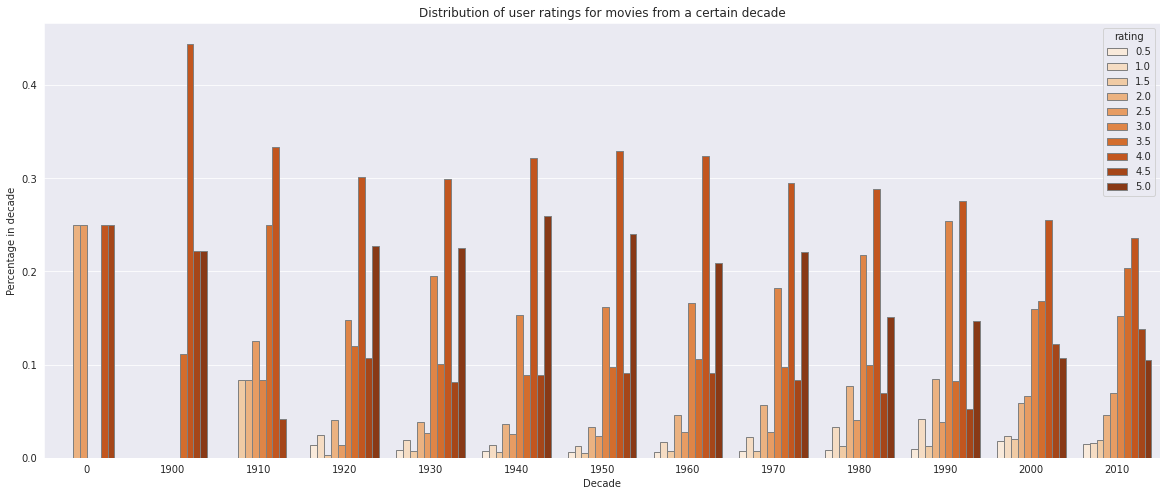

In [ ]:
# Calculate the histogram for each decade and rating
histogram_data_spark = top_rated.groupBy("decade", "rating").count()

# Calculate the total count for each decade
total_counts = top_rated.groupBy("decade").count().withColumnRenamed("count", "total_count")

# Join the dataframes to calculate the percentage
percentage_data_spark = histogram_data_spark.join(total_counts, "decade")
percentage_data_spark = percentage_data_spark.withColumn("percentage", percentage_data_spark["count"] / percentage_data_spark["total_count"])

# Convert Spark DataFrame to Pandas when ready for plotting
percentage_data_pandas = percentage_data_spark.toPandas()

# Specify the order of decades
decade_order = sorted(percentage_data_pandas["decade"].unique())

# Specify the order of ratings
hue_order = sorted(percentage_data_pandas["rating"].unique())

plt.figure(figsize=(20, 8))
sns.barplot(data=percentage_data_pandas, x="decade", y="percentage", hue="rating", order=decade_order, hue_order=hue_order, palette="Oranges", edgecolor="grey")
plt.xlabel("Decade")
plt.ylabel("Percentage in decade")
plt.title("Distribution of user ratings for movies from a certain decade")
plt.show()

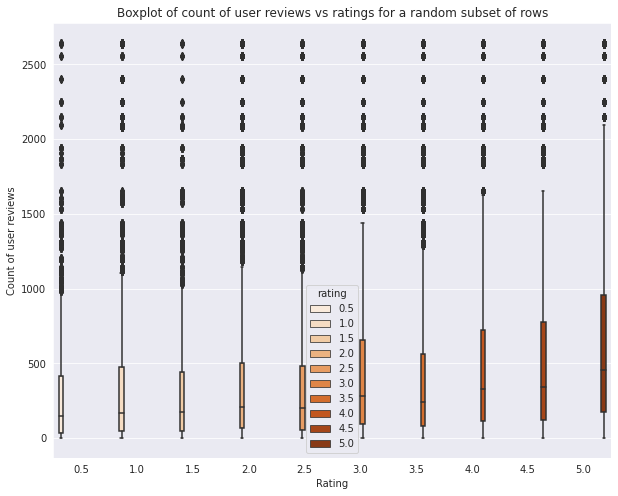

In [ ]:
# Get counts of reviews for each movie
windowSpec = Window.partitionBy("movieId")
top_rated = top_rated.withColumn("count", count("userId").over(windowSpec))
top_rated = top_rated.withColumn("rating", top_rated["rating"].cast("string"))
top_rated = top_rated.orderBy("rating")

# Convert Spark DataFrame to Pandas when ready for plotting
top_rated_pandas = top_rated.toPandas()

plt.figure(figsize=(10, 8))
sns.boxplot(data=top_rated_pandas, x="rating", y="count", hue="rating", palette="Oranges")
plt.xlabel("Rating")
plt.ylabel("Count of user reviews")
plt.title("Boxplot of count of user reviews vs ratings for a random subset of rows")
plt.show()


### Modeling

The recommender system will work in a following way. Machine Learning model will be provided the userId and various movie characteristics such as title, decade and genre. Based on these features, it will output a rating this user would give to this movie.

In [ ]:
# Split data into training and test sets
(trainingData, testData) = all_df.randomSplit([0.7, 0.3], 24)

In [ ]:
# Initializing string indexers for userId, title, decade and rating
string_indexer1 = StringIndexer(inputCol="userId", outputCol="user_indexed").setHandleInvalid("keep")
string_indexer2 = StringIndexer(inputCol="title", outputCol="title_indexed").setHandleInvalid("keep")
string_indexer3 = StringIndexer(inputCol="decade", outputCol="decade_indexed").setHandleInvalid("keep")
string_indexer4 = StringIndexer(inputCol="rating", outputCol="rating_indexed").setHandleInvalid("keep")

In [ ]:
# Vector assembler
feature_assembler = VectorAssembler(
    inputCols=[
        "user_indexed",
        "title_indexed",
        "decade_indexed",
        "Crime",
        "Romance",
        "Thriller",
        "Adventure",
        "Drama",
        "War",
        "Documentary",
        "Fantasy",
        "Mystery",
        "Musical",
        "Animation",
        "Film-Noir",
        "(no genres listed)",
        "IMAX",
        "Horror",
        "Western",
        "Comedy",
        "Children",
        "Action",
        "Sci-Fi"],
    outputCol="training_features")

In [ ]:
# Logistic regression will be used as a model behind the recommender system
lr = LogisticRegression(labelCol="rating_indexed", featuresCol="training_features")

In [ ]:
# Define pipeline
pipeline = Pipeline(stages=[string_indexer1, string_indexer2, string_indexer3, string_indexer4, feature_assembler, lr])

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="rating_indexed", predictionCol="prediction", metricName="accuracy")

#### Cross-validation

In [ ]:
# Define hyperparameter search space
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

In [ ]:
cv = CrossValidator() \
  .setEstimator(pipeline) \
  .setEvaluator(evaluator) \
  .setEstimatorParamMaps(paramGrid) \
  .setNumFolds(2)

In [ ]:
model = cv.fit(trainingData)

#### Test best model

In [ ]:
predictions = model.transform(testData).cache()

In [ ]:
predictions.select("prediction", "rating_indexed", "training_features").show()

+----------+--------------+--------------------+
|prediction|rating_indexed|   training_features|
+----------+--------------+--------------------+
|       0.0|           3.0|(23,[0,1,6,10,13,...|
|       0.0|           0.0|(23,[0,1,6,10,13,...|
|       0.0|           0.0|(23,[0,1,6,10,13,...|
|       0.0|           6.0|(23,[0,1,6,10,13,...|
|       0.0|           0.0|(23,[0,1,6,10,13,...|
|       0.0|           1.0|(23,[0,1,6,10,13,...|
|       0.0|           0.0|(23,[0,1,6,10,13,...|
|       0.0|           0.0|(23,[0,1,6,10,13,...|
|       0.0|           1.0|(23,[0,1,6,10,13,...|
|       0.0|           1.0|(23,[0,1,6,10,13,...|
|       0.0|           1.0|(23,[0,1,6,10,13,...|
|       0.0|           0.0|(23,[0,1,6,10,13,...|
|       0.0|           2.0|(23,[0,1,6,10,13,...|
|       0.0|           5.0|(23,[0,1,5,6,21],...|
|       1.0|           6.0|(23,[0,1,5,6,21],...|
|       0.0|           1.0|(23,[0,1,5,6,21],...|
|       0.0|           1.0|(23,[0,1,5,6,21],...|
|       1.0|        

In [ ]:
# The test error is quite high
# Possible solution is to use more data and/or a different model
evaluator = MulticlassClassificationEvaluator(
    labelCol="rating_indexed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

Test Error = 0.710744 


In [ ]:
spark.stop()